# Make Animation from pickels files

In [1]:
#Standard Header used on the projects

#first the major packages used for math and graphing
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import platform
from joblib import Parallel, delayed

#Custome graph format style sheet
#plt.style.use('Prospectus.mplstyle')

#If being run by a seperate file, use the seperate file's graph format and saving paramaeters
#otherwise set what is needed
if not 'Saving' in locals():
    Saving = True
if not 'Titles' in locals():
    Titles = True
if not 'Ledgends' in locals():
    Ledgends = True
if not 'FFormat' in locals():
    FFormat = '.eps'

In [2]:
import multiprocessing
from joblib import Parallel, delayed
num_jobs=30

In [3]:
## Task specific imports
import os as os
import keras.utils as image
import glob
from PIL import Image, ImageDraw
import pickle

2024-01-07 12:03:49.874971: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import math
 

## Choosing Platform
Working is beinging conducted on several computers, and author needs to be able to run code on all without rewriting..  This segment of determines which computer is being used, and sets the directories accordingly.

In [5]:
HostName = platform.node()

if HostName == "Server":
    Computer = "Desktop"   
elif HostName[-6:] == 'wm.edu':
    Computer = "SciClone"
elif HostName == "SchoolLaptop":
    Computer = "LinLap"
elif HostName == "WTC-TAB-512":
    Computer = "PortLap"
else:
    Computer = "WinLap"
    
if Computer ==  "SciClone":
    rootfolder = '/sciclone/scr10/dchendrickson01/EFIT/'
    
else:
    asdfasdf

## Load data

In [6]:
Case = '15m10XRfRq'
CasesAtaTime = 2
FilesAtTime = 5
ProcessPerFile = 5
Position = 0 #0 Energy, 1 X axis, 2 Y Axis, 3 X axis
skips = 2 #1 every data point, or skip what modulous

imFolder=rootfolder+Case+'/'
fileNames = glob.glob(imFolder+'Movements*.p')

Views=[]

In [7]:
fileName = imFolder+'Parameters.p'

file=open(fileName,'rb')
Parameters=pickle.load(file)

file.close()


In [8]:
xmax = Parameters["LargestXnode"]
ymax = Parameters["LargestYnode"]
zmax = Parameters["LargestZnode"]
gridStartWeb = Parameters["WidthStartWebNode"]
gridEndWeb = Parameters["WidthEndWebNode"]
gridEndFoot = Parameters["HeightEndFootNode"]
gridStartHead = Parameters["HeightStartHeadNode"]
gridStartHeadWidth = Parameters["WidthStartHeadNode"]
gridEndHeadWidth = Parameters["WidthEndHeadNode"]
DataBucketSize = Parameters["SaveEveryXStep"]

In [9]:
Parameters

{'AirCut': False,
 'RailShape': True,
 'Flaw': False,
 'Length': 20,
 'Width': 0.1524,
 'Height': 0.1524,
 'SaveFolder': '/sciclone/scr10/dchendrickson01/EFIT/15m10XRfRq/',
 'RunTitle': '20m Rail At 10x long for 1k FP',
 'TiesIncluded': 0,
 'GridDesignFrequency': 49720,
 'InputSignalFrequency': 16300,
 'SimulationCycleLength': 60,
 'ForcingFuctionNumber': 6,
 'PerWheelForce': 173000,
 'PoisonsRatio': 0.29,
 'YoungsModulous': 200000000000,
 'MaterialDensity': 7800,
 'LongitudinalWaveSpeed': 5796.653896162343,
 'TransverseWaveSpeeed': 3152.519949406393,
 'TimeStepsSimLength': 12130,
 'GridLengthNodes': 4000,
 'GridWidthNodes': 30,
 'GridHeightNodes': 30,
 'LargestXnode': 3786,
 'LargestYnode': 29,
 'LargestZnode': 29,
 'SaveEveryXStep': 250,
 'HeightStartHeadNode': 19,
 'WidthStartWebNode': 11,
 'WidthEndWebNode': 18,
 'HeightEndFootNode': 6,
 'WidthStartHeadNode': 5,
 'WidthEndHeadNode': 24,
 'AbsorberLengthNodes': 101,
 'AbsorptionPerNode': 0.5,
 'ExpectedGoodData': 9051.593811466631}

## Image making functions

In [10]:
def getFigData(fileName, Position, skips, xStart, xEnd, yStart, yEnd, zStart, zEnd):
    
    file=open(fileName,'rb')
    temp = pickle.load(file)
    file.close()
    
    Data = temp[Position][:,:,:,0::skips]
    
    del temp


    if xStart == xEnd:
        ReturnData = Data[xStart,:,:,:]
        ReturnData[:gridStartWeb-1,gridEndFoot+2:gridStartHead-2] = np.nan
        ReturnData[:gridStartHeadWidth-1,gridStartHead-2:] = np.nan
        ReturnData[gridEndWeb+2:,gridEndFoot+2:gridStartHead-1] = np.nan
        ReturnData[gridEndHeadWidth+4:,gridStartHead-1:] = np.nan
        
    elif yStart == yEnd:
        ReturnData = Data[:,yStart,:,:]
    elif zStart == zEnd:
        ReturnData = Data[:,:,zStart,:]
    else:
        print('Error no dimmension is a plane')
        ReturnData = []
        
        
    return ReturnData, int(fileName[-5:][:3])

In [11]:
def SimpleFig(Data, t, v, figW, figH, Folder):
    
    fig = plt.figure(figsize=(figH,figW), dpi=300)

    Data = Data.T
    
    #print(Data.shape)
    
    plt.contourf(Data, v, cmap=plt.cm.jet)
    plt.title(Folder+' '+str(t))
    plt.savefig(imFolder+Folder+'/DataFrame'+str(t).zfill(5)+'.png')
    
    fig.clf()
    plt.close(fig)
    del fig

    return 0

In [12]:
def CaseImage(View):
    imfolder = rootfolder + Case + '/'+View+'/'
    files = glob.glob(os.path.join(imfolder, '*.png'))
    files.sort()
    images = []

    for file in files:
        images.append(image.load_img(file))
    try:
        images[0].save(rootfolder + Case + '/Animated_'+View+'.gif',
           save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)
    except:
        pass
    return 0

In [13]:
def runCase(Case, skips):
    
    Position = Case[7]
    xStart = Case[0]
    xEnd = Case[1]
    yStart = Case[2]
    yEnd = Case[3]
    zStart = Case[4]
    zEnd = Case[5]
    Folder = Case[6]
    
    temp = Parallel(n_jobs=FilesAtTime)(delayed(getFigData)
                                        (fileName, Position, skips, xStart, xEnd, yStart, yEnd, zStart, zEnd) 
                                        for fileName in fileNames[:5])
    
    StackData = np.zeros((temp[0][0].shape[0],temp[0][0].shape[1],1))
    
    for group in temp:
        try:
            StackData = np.concatenate((StackData,group[0]),axis=2)
        except:
            pass
    del temp
    
    EMin = np.min(StackData)
    EMax = np.max(StackData)
    v = np.linspace(EMin, EMax, 30, endpoint=True)[0:20]
    
    if os.path.isdir(imFolder+Folder):
        pass
    else:
        os.makedirs(imFolder+Folder)
        
    figW = 6
    figH = figW * (StackData.shape[0]/StackData.shape[1])
    
    #print(StackData[:,:,1].T.shape,StackData[:,:,17].T.shape,StackData[:,:,99].T.shape)
    
    #Parallel(n_jobs=ProcessPerFile)(delayed(SimpleFig)
    #                                (StackData[:,:,i], i, v, figW, figH, Folder)
    #                                for i in range(StackData.shape[2]))
    for i in range(StackData.shape[2]):
        a = SimpleFig(StackData[:,:,i], i, v, figW, figH, Folder)
    
    del StackData
    #temp = CaseImage(Folder)

In [14]:
def getStackData(Case, skips):
    
    Position = Case[7]
    xStart = Case[0]
    xEnd = Case[1]
    yStart = Case[2]
    yEnd = Case[3]
    zStart = Case[4]
    zEnd = Case[5]
    Folder = Case[6]
    
    temp = Parallel(n_jobs=FilesAtTime)(delayed(getFigData)
                                        (fileName, Position, skips, xStart, xEnd, yStart, yEnd, zStart, zEnd) 
                                        for fileName in fileNames[:5])
    
    StackData = np.zeros((temp[0][0].shape[0],temp[0][0].shape[1],1))
    
    for group in temp:
        try:
            StackData = np.concatenate((StackData,group[0]),axis=2)
        except:
            pass
    del temp
    
    return StackData

## make all the frames of all the cases

In [15]:

GifsToMake=[]
GifsToMake.append([xmax-4,xmax-4,0,ymax,0,zmax,"EndM4",1])
GifsToMake.append([xmax-2,xmax-2,0,ymax,0,zmax,"EndM2",1])
GifsToMake.append([xmax-6,xmax-6,0,ymax,0,zmax,"EndM6",1])
GifsToMake.append([0,xmax,gridEndHeadWidth-1,gridEndHeadWidth-1,gridStartHead,zmax,"HeadEnd",2])
GifsToMake.append([0,xmax,gridStartHeadWidth+1,gridStartHeadWidth+1,gridStartHead,zmax,"HeadStart",0])
GifsToMake.append([0,xmax,gridStartHeadWidth,gridEndHeadWidth,zmax-3,zmax-3,"TopSurface",3])
GifsToMake.append([0,xmax,gridStartHeadWidth,gridStartHeadWidth,gridStartHead,zmax,"LeftSurface",1])
GifsToMake.append([0,xmax,gridStartWeb,gridStartWeb,gridEndFoot,gridStartHead,"RightSurface",1])
GifsToMake.append([0,xmax,0,ymax,int((zmax - gridStartHead)/2)+gridStartHead,int((zmax - gridStartHead)/2)+gridStartHead,"Head",0])
GifsToMake.append([0,xmax,gridStartWeb,gridEndWeb,int(zmax/2),int(zmax/2),"Mid",0])
GifsToMake.append([0,xmax,int(ymax/2),int(ymax/2),0,zmax,"Vert",0])
GifsToMake.append([0,xmax,gridStartWeb+1,gridStartWeb+1,gridEndFoot,gridStartHead,"WebStart",1])
GifsToMake.append([0,xmax,gridEndWeb-1,gridEndWeb-1,gridEndFoot,gridStartHead,"WebEnd",1])


In [16]:
Data = getStackData(GifsToMake[11],1)

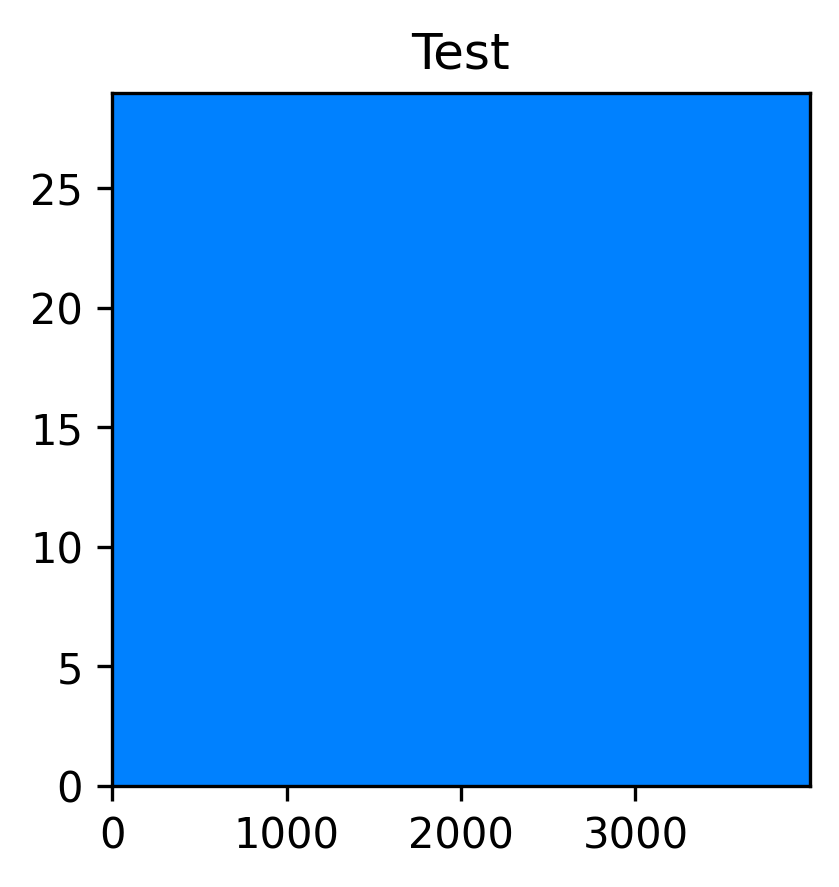

In [17]:
fig = plt.figure(figsize=(3,3), dpi=300)

plt.contourf(Data[:,:,250].T, cmap=plt.cm.jet)
plt.title('Test')
plt.show()


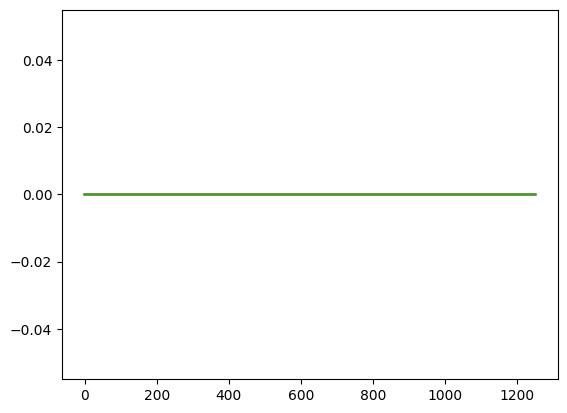

In [18]:
fig = plt.figure()
plt.plot(Data[20,20,:])
plt.plot(Data[27,20,:])
plt.plot(Data[20,20,:]-Data[27,20,:])
plt.show()

## FingerPrinting

In [19]:
import CoreFunctions as cf

In [20]:
TP1 = getThumbprint2(Data[20,20,:], wvt='db2', ns=1000, scalespace = 1, numslices=5, slicethickness=0.12, 
                  valleysorpeaks='both', normconstant=1, plot=True)

NameError: name 'getThumbprint2' is not defined

In [ ]:
TP2 = getThumbprint2(Data[27,20,:], wvt='db2', ns=1000, scalespace = 1, numslices=5, slicethickness=0.12, 
                  valleysorpeaks='both', normconstant=1, plot=True)

In [ ]:
TPD = getThumbprint2(Data[20,20,:]-Data[27,20,:], wvt='db2', ns=1000, scalespace = 1, numslices=5, slicethickness=0.12, 
                  valleysorpeaks='both', normconstant=1, plot=True)